# 1. Import and path setting
Installing Kagglehub and downloading dataset via Kaggle API

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

/Users/yannik/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/yannik/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


Defining the paths to training, validation, and testing folder. Counting the number of folders.

In [3]:
import os

# Define the dataset path
root_folder = "/Users/yannik/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")


Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33


Importing all libraries

In [4]:
import random

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 2 ResNet50 base model in plain PyTorch

In [11]:
# Check if MPS is available ad set the device
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


/Users/yannik/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/_tensor_str.py:145: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1736083028696/work/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  nonzero_finite_vals = torch.masked_select(


In [9]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()

        # Initialize the base model without pre-trained weights
        self.base_model = models.resnet50(pretrained=False)
        
        # Modify the final fully connected layer to match the pre-trained model from the .pth file
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, 120)
        
        # Initialize the base model and load custom weights
        state_dict = torch.load('/Users/yannik/Documents/DataScientest_Bootcamp/Planting_parents_project/models_local_save/PyTorch/ResNet50/ResNet50-Plant-model-80.pth', map_location=mps_device)
        self.base_model.load_state_dict(state_dict)
        
        # Modify the classifier
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # Remove the original FC layer
        
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)  # Return raw logits
        return x

In [10]:
# Create an instance of the CustomResNet50 class
num_classes = 38
model_resnet50 = CustomResNet50(num_classes)

# Freeze all layers of the base model
for param in model_resnet50.base_model.parameters():
    param.requires_grad = False

# Ensure only the classifier parameters are trainable
for param in model_resnet50.classifier.parameters():
    param.requires_grad = True

# Move the model to the MPS device
model_resnet50= model_resnet50.to(mps_device)

/Users/yannik/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yannik/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/k_/2bfsctdx2z91qswg8rrs20lh0000gn/T/ipykernel_1431/3428952010.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a 

In [11]:

# Check the status (frozen/unfrozen) of all layers
def print_layer_status(model):
    for name, param in model.named_parameters():
        status = "Unfrozen" if param.requires_grad else "Frozen"
        print(f"{name}: {status}")

# Usage
print_layer_status(model_resnet50)

base_model.conv1.weight: Frozen
base_model.bn1.weight: Frozen
base_model.bn1.bias: Frozen
base_model.layer1.0.conv1.weight: Frozen
base_model.layer1.0.bn1.weight: Frozen
base_model.layer1.0.bn1.bias: Frozen
base_model.layer1.0.conv2.weight: Frozen
base_model.layer1.0.bn2.weight: Frozen
base_model.layer1.0.bn2.bias: Frozen
base_model.layer1.0.conv3.weight: Frozen
base_model.layer1.0.bn3.weight: Frozen
base_model.layer1.0.bn3.bias: Frozen
base_model.layer1.0.downsample.0.weight: Frozen
base_model.layer1.0.downsample.1.weight: Frozen
base_model.layer1.0.downsample.1.bias: Frozen
base_model.layer1.1.conv1.weight: Frozen
base_model.layer1.1.bn1.weight: Frozen
base_model.layer1.1.bn1.bias: Frozen
base_model.layer1.1.conv2.weight: Frozen
base_model.layer1.1.bn2.weight: Frozen
base_model.layer1.1.bn2.bias: Frozen
base_model.layer1.1.conv3.weight: Frozen
base_model.layer1.1.bn3.weight: Frozen
base_model.layer1.1.bn3.bias: Frozen
base_model.layer1.2.conv1.weight: Frozen
base_model.layer1.2.bn1.w

Quick Check if everything is set up correctly

In [10]:
# 1. Create a dummy input tensor (adjust the size according to your expected input)
dummy_input = torch.randn(1, 3, 224, 224).to(mps_device)

# 2 & 3. Pass it through your model and check the output shape
with torch.no_grad():
    output = model_resnet50(dummy_input)
print(f"Output shape: {output.shape}")

# 4. Verify the model is on the correct device
print(f"Model device: {next(model_resnet50.parameters()).device}")

# 5. Check if all parameters are on the same device
devices = set(p.device for p in model_resnet50.parameters())
print(f"All parameters on same device: {len(devices) == 1}")

# 6. Print the model architecture
print(model_resnet50)

# 7. Check if the output sums to 1 (since it's softmax)
print(f"Output sums to 1: {torch.isclose(output.sum(), torch.tensor(1.0))}")

Output shape: torch.Size([1, 38])
Model device: mps:0
All parameters on same device: True
CustomResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

All checks passed!

**Building the data generators**

In [5]:
# 1. & 2. Data transforms (only rescaling)
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

# Dataset and DataLoader setup
train_dataset = datasets.ImageFolder(train_path, data_transform)
valid_dataset = datasets.ImageFolder(valid_path, data_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [13]:
# Training and validation functions 
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [14]:
# Set the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet50.parameters(), lr=0.0001)

# Create a history object to store the accuracies and losses during training
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Set
best_val_acc = 0
best_model_path = '../../models_local_save/PyTorch/ResNet50/best_model_resnet50_v3.pth'

num_epochs = 50
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model_resnet50, train_loader, optimizer, criterion, mps_device)
    val_loss, val_acc = validate(model_resnet50, valid_loader, criterion, mps_device)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model after each epoch
    torch.save(model_resnet50.state_dict(), f'../../models_local_save/PyTorch/ResNet50/model_resnet50_v3_epoch_{epoch}.pth')

    # Check if the current model is performing best and save it
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_resnet50.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")

print("Training complete")

Epoch 1/50
Train Loss: 0.9826, Train Acc: 0.8357
Val Loss: 0.1424, Val Acc: 0.9785
New best model saved with validation accuracy: 0.9785
Epoch 2/50
Train Loss: 0.1684, Train Acc: 0.9642
Val Loss: 0.0912, Val Acc: 0.9851
New best model saved with validation accuracy: 0.9851
Epoch 3/50
Train Loss: 0.0987, Train Acc: 0.9769
Val Loss: 0.0358, Val Acc: 0.9920
New best model saved with validation accuracy: 0.9920
Epoch 4/50
Train Loss: 0.0703, Train Acc: 0.9828
Val Loss: 0.0612, Val Acc: 0.9921
New best model saved with validation accuracy: 0.9921
Epoch 5/50
Train Loss: 0.0574, Train Acc: 0.9860
Val Loss: 0.0347, Val Acc: 0.9936
New best model saved with validation accuracy: 0.9936
Epoch 6/50
Train Loss: 0.0488, Train Acc: 0.9875
Val Loss: 0.0729, Val Acc: 0.9932
Epoch 7/50
Train Loss: 0.0381, Train Acc: 0.9900
Val Loss: 0.1086, Val Acc: 0.9915
Epoch 8/50
Train Loss: 0.0327, Train Acc: 0.9911
Val Loss: 0.1048, Val Acc: 0.9927
Epoch 9/50
Train Loss: 0.0291, Train Acc: 0.9922
Val Loss: 0.2526,

In [15]:
import csv

with open("history_v3.csv", "w", newline="") as fp:
    writer = csv.DictWriter(fp, fieldnames=history.keys())
    writer.writeheader()  # Write the header row
    rows = [dict(zip(history.keys(), values)) for values in zip(*history.values())]
    writer.writerows(rows)  # Write the data rows
    print('Done writing dict to a csv file')

Done writing dict to a csv file


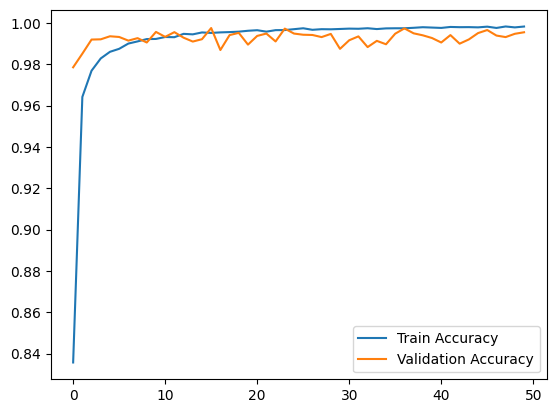

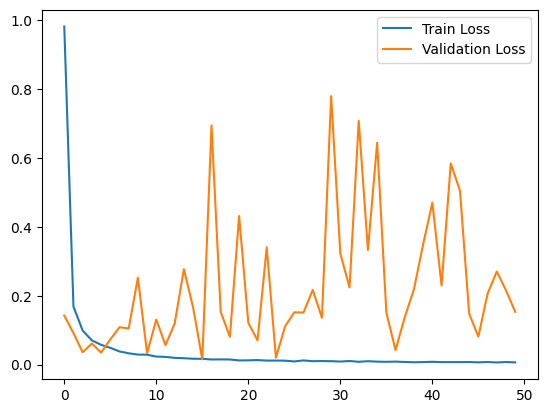

In [42]:
# history = pd.read_csv("../../models_local_save/PyTorch/ResNet50/history_v2.csv")

# Plot the metrics
plt.figure()
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

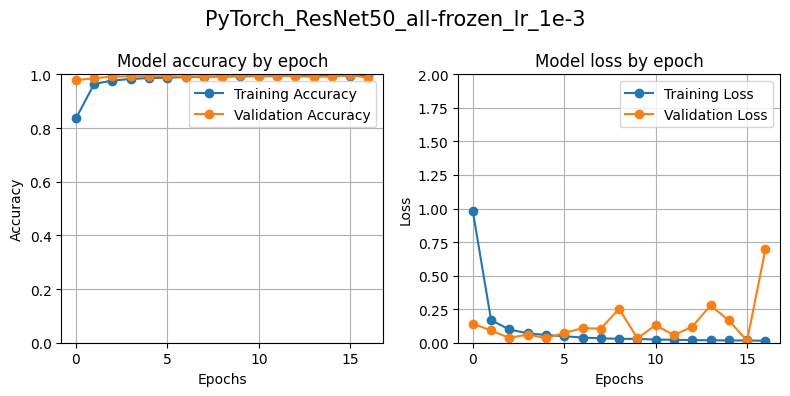

In [6]:
history = pd.read_csv("../../models_local_save/PyTorch/ResNet50/history_v3.csv")


fig= plt.figure(figsize=(8,4))
fig.suptitle("PyTorch_ResNet50_all-frozen_lr_1e-3", fontsize=15)

# Plot accuracy
plt.subplot(121)
plt.plot(history["train_acc"][:17], label='Training Accuracy', marker='o')
plt.plot(history["val_acc"][:17], label='Validation Accuracy', marker='o')
plt.title('Model accuracy by epoch')
plt.xlabel('Epochs')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(122)
plt.plot(history["train_loss"][:17], label='Training Loss', marker='o')
plt.plot(history["val_loss"][:17], label='Validation Loss', marker='o')
plt.title('Model loss by epoch')
plt.xlabel('Epochs')
plt.ylim([0,2])
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [7]:
history = pd.read_csv("../../models_local_save/PyTorch/ResNet50/history_v2.csv")

print(history["train_acc"].max())
print(history["train_acc"].max())
print(history["train_loss"].min())
print(history["val_loss"].min())

0.9965431396258624
0.9965431396258624
0.0319664614638907
0.0347066865413267


# 3 Using Grad-CAM for interpretability

In [12]:
# Load the best performing ResNet50 model

num_classes = 38

model_name = "best_model_resnet50_v2.pth"
model = CustomResNet50(num_classes)
model_path = os.path.join("../../models_local_save/PyTorch/ResNet50/", model_name)
model.load_state_dict(torch.load(model_path))
model.eval()

model = model.to(mps_device)

/var/folders/k_/2bfsctdx2z91qswg8rrs20lh0000gn/T/ipykernel_33282/3428952010.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/Users/yannik/Docum

In [78]:
print(model)

CustomResNet50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [13]:
print(model.base_model.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


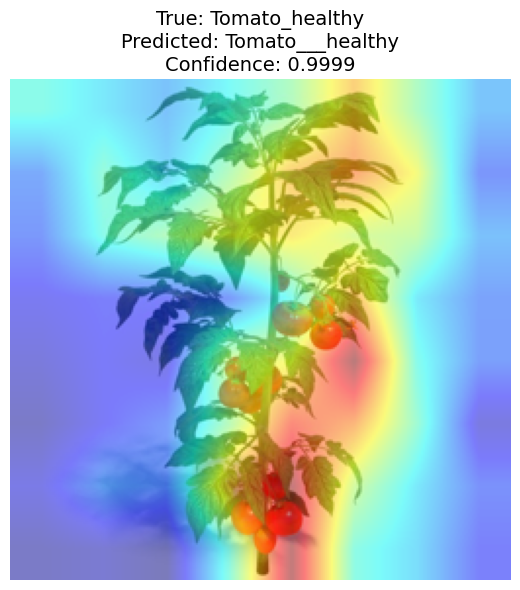

In [14]:
# Define the target layer for the Grad-CAM: here, I use the last conv layer (conv3) of the last bottleneck group of the ResNet50 base model
target_layer_first = model.base_model.conv1
target_layer_second = model.base_model.layer1[0].conv1
target_layer_third = model.base_model.layer1[0].conv2
target_layer_middle = model.base_model.layer2[-1].conv3
target_layer_last = model.base_model.layer4[-1].conv3

target_layer = target_layer_last

# Construct Grad-CAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Load and preprocess the image
test_image_folder = "../src/web_images_test/"
image_names = ["Apple_Cedar_Rust.jpg", "Corn_maize.jpg", "Potato_early_blight.jpg", "Strawberry_leaf_spot_blight_scorch.jpg", "Tomato_healthy.jpg"]
choice = 4 # number between 0-4
image_path = os.path.join(test_image_folder, image_names[choice])
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
input_tensor = preprocess(image).unsqueeze(0).to(mps_device)


# Set the true class and the mapping between class_names and indices
true_classes = ["Apple Cedar Rust", "Corn_maize", "Potato_early_blight", "Strawberry_leaf_spot_blight_scorch", "Tomato_healthy"]
true_class = true_classes[choice]
class_names = train_dataset.classes

# Get the predicted class
with torch.no_grad():
    output = model(input_tensor)
    # print("Output:", output)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # print("Probabilities:", probabilities)
    confidence, predicted_idx = torch.max(probabilities, 1)
    predicted_class = class_names[predicted_idx.item()]

# Transfer data back to CPU and convert to numpy
confidence = confidence.cpu().data.numpy()[0]

# Generate class activation map
grayscale_cam = cam(input_tensor=input_tensor, targets=None)
grayscale_cam = grayscale_cam[0, :]

# Convert the original image to RGB numpy array
rgb_img = np.array(image.convert('RGB').resize((256, 256))) / 255

# Overlay the CAM on the original image
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(visualization)
plt.axis('off')
plt.title(f"True: {true_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.4f}", fontsize=14)
plt.tight_layout()
plt.show()

In [30]:
# Create a custom dataset class that reads the images in the test folder and extracts the class information from the filename
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        # print(f"Number of images found: {len(self.images)}")
        # print(f"First few image names: {self.images[:5]}")
        
        self.class_names = sorted(list(set([self._get_class_from_filename(f) for f in self.images])))
        # print(f"Extracted class names: {self.class_names}")
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.class_names)}
        self.samples = [(os.path.join(root_dir, img), self.class_to_idx[self._get_class_from_filename(img)]) 
                        for img in self.images]

    def _get_class_from_filename(self, filename):
        # Extract class name by removing numbers and file extension
        class_name = ''.join([i for i in filename if not i.isdigit()]).rsplit('.', 1)[0]
        return class_name
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_idx, img_path

In [31]:
# Have a look at the original class indices that are used in the model training
# idx_to_class stores the mapping between indices and class names given by the subfolder names
train_dataset = ImageFolder(root=train_path)
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [32]:
# Function to get prediction and CAM
def get_prediction_and_cam(model, image_path):
    image = Image.open(image_path)
    input_tensor = preprocess(image).unsqueeze(0).to(mps_device)
    
    with torch.no_grad():
        output = model(input_tensor)
        # print("Output:", output)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        # print("Probabilities:", probabilities)
        confidence, predicted_idx = torch.max(probabilities, 1)
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
    rgb_img = np.array(image.convert('RGB').resize((256, 256))) / 255
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    return predicted_idx.item(), confidence, cam_image


In [101]:
# Define the target layer for the Grad-CAM
target_layer_first = model.base_model.conv1
target_layer_second = model.base_model.layer1[0].conv1
target_layer_third = model.base_model.layer1[0].conv2
target_layer_middle = model.base_model.layer2[-1].conv3
target_layer_last = model.base_model.layer4[-1].conv3

target_layer = target_layer_last

# Construct Grad-CAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Create test dataset to acces
test_dataset = CustomTestDataset(root_dir=test_path)

# Process all images

results = []
for idx in range(len(test_dataset)):
    image, true_class, img_path = test_dataset[idx]
    predicted_idx, confidence, cam_image = get_prediction_and_cam(model, img_path)
    true_class_name = test_dataset.class_names[true_class]
    # predicted_class_name = test_dataset.class_names[predicted_idx]
    predicted_class_name = train_dataset.classes[predicted_idx]
    results.append((true_class_name, predicted_class_name, np.round(confidence[0].detach().item(),3), cam_image))
    #print(f"True: {true_class_name}, Predicted: {predicted_class_name}")

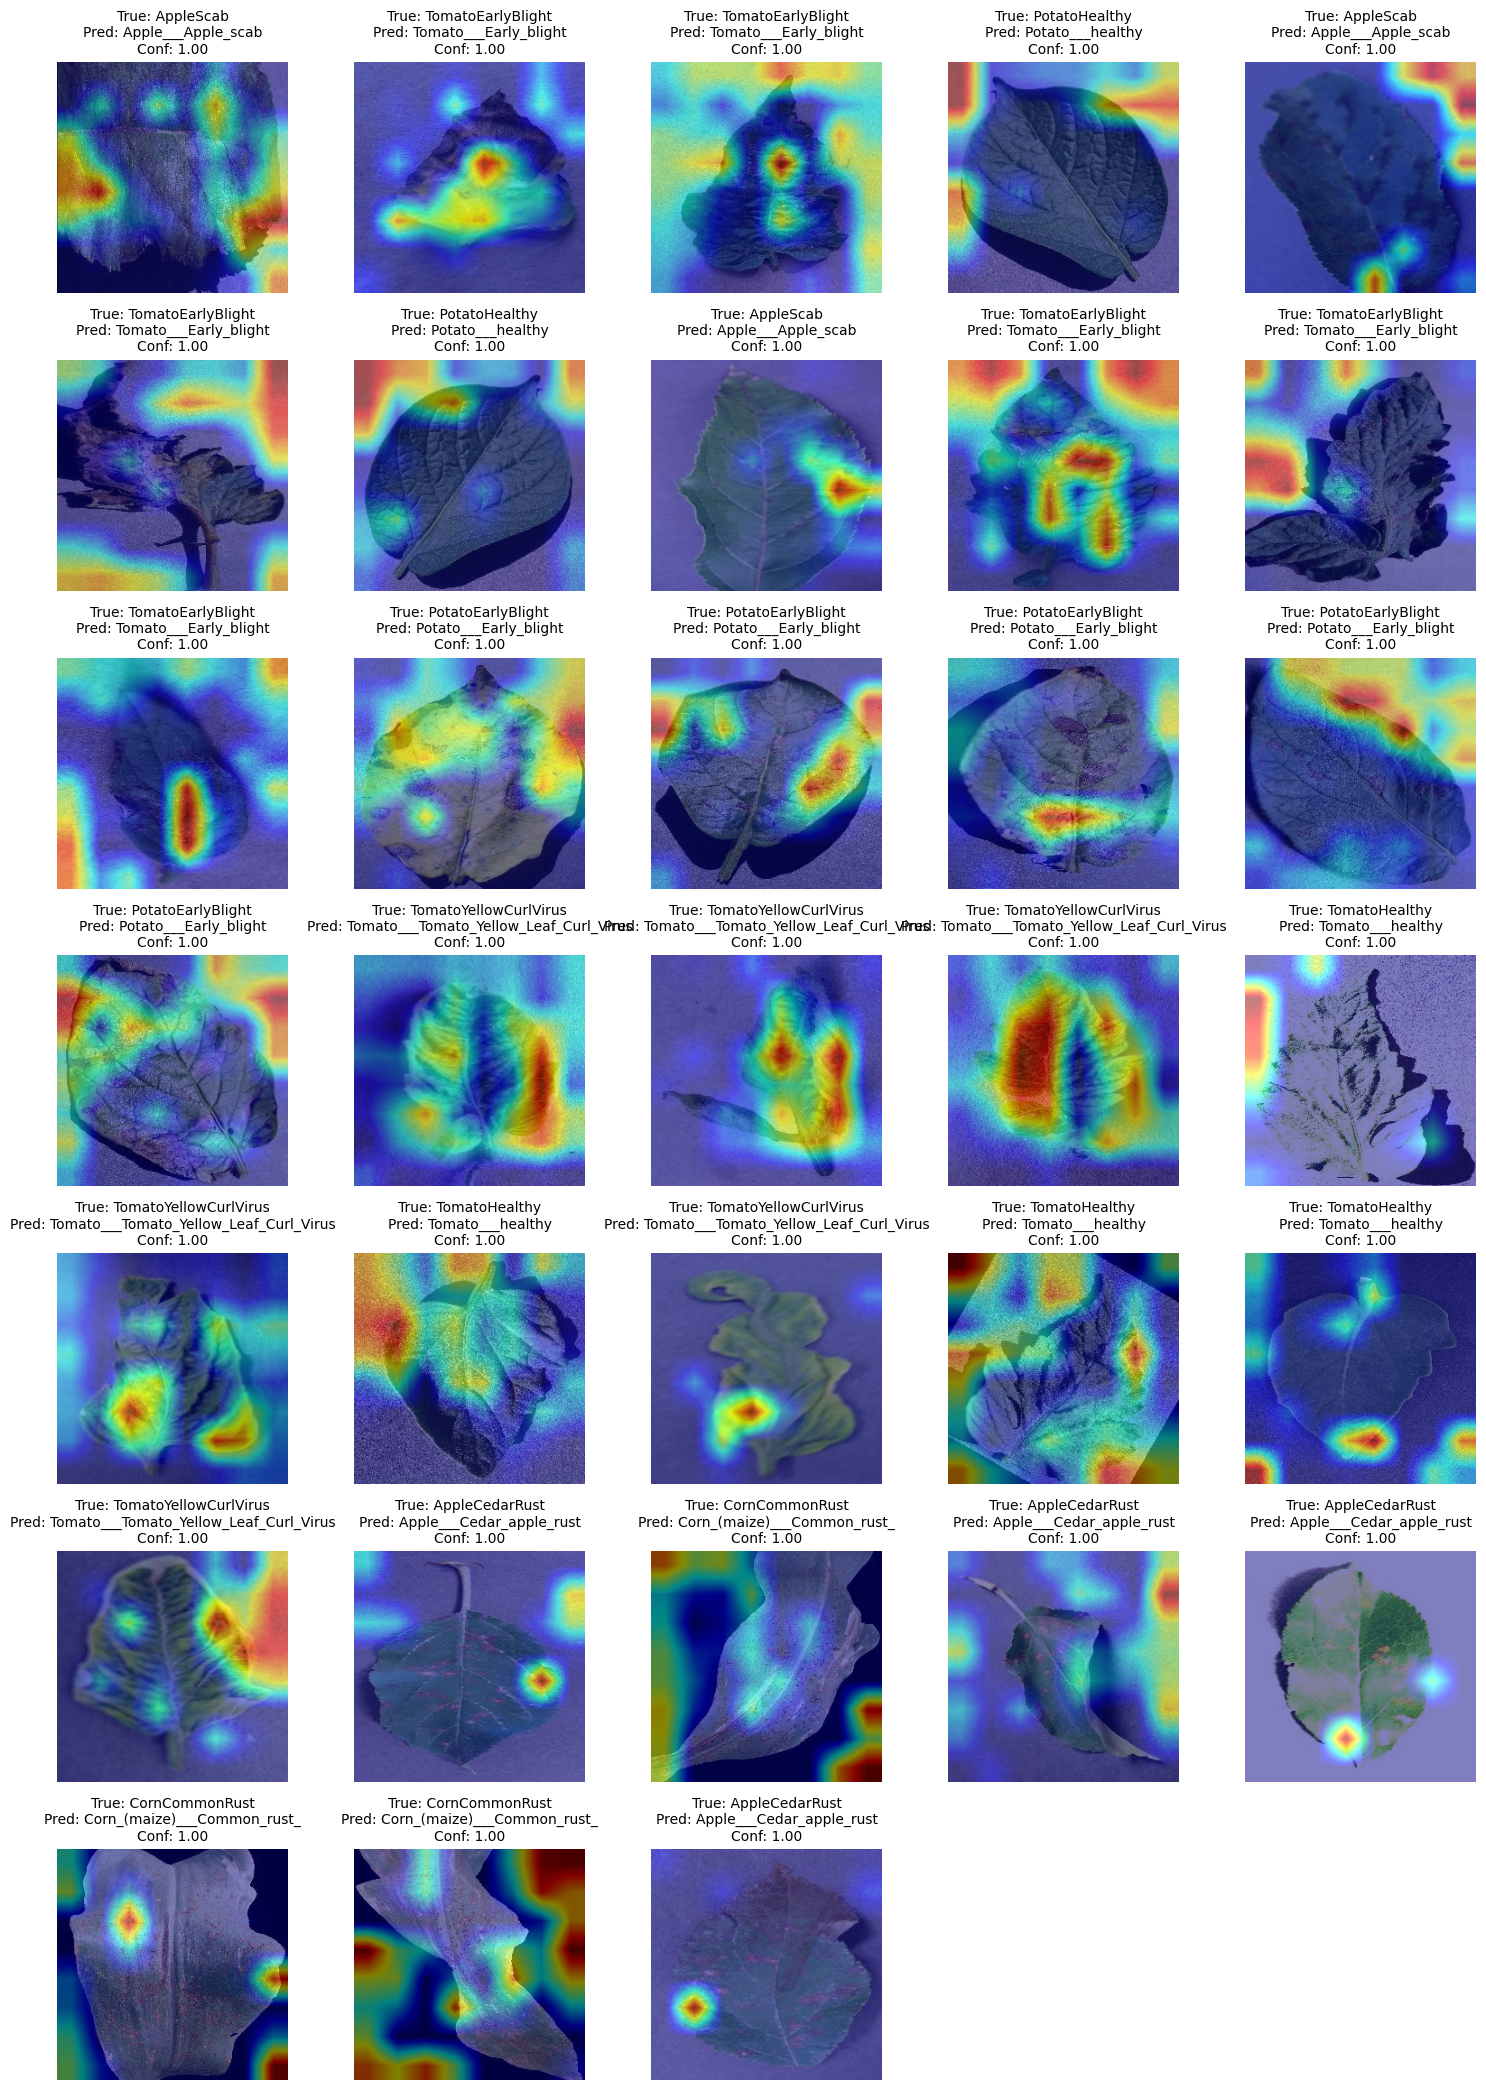

In [102]:
# Display results in a table
num_cols = 5
num_rows = (len(results) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

for i, (true_class, pred_class, confidence, cam_image) in enumerate(results):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.imshow(cam_image)
    ax.axis('off')
    ax.set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}", fontsize=10)

# Remove empty subplots
for i in range(len(results), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

Check random set from the valid set

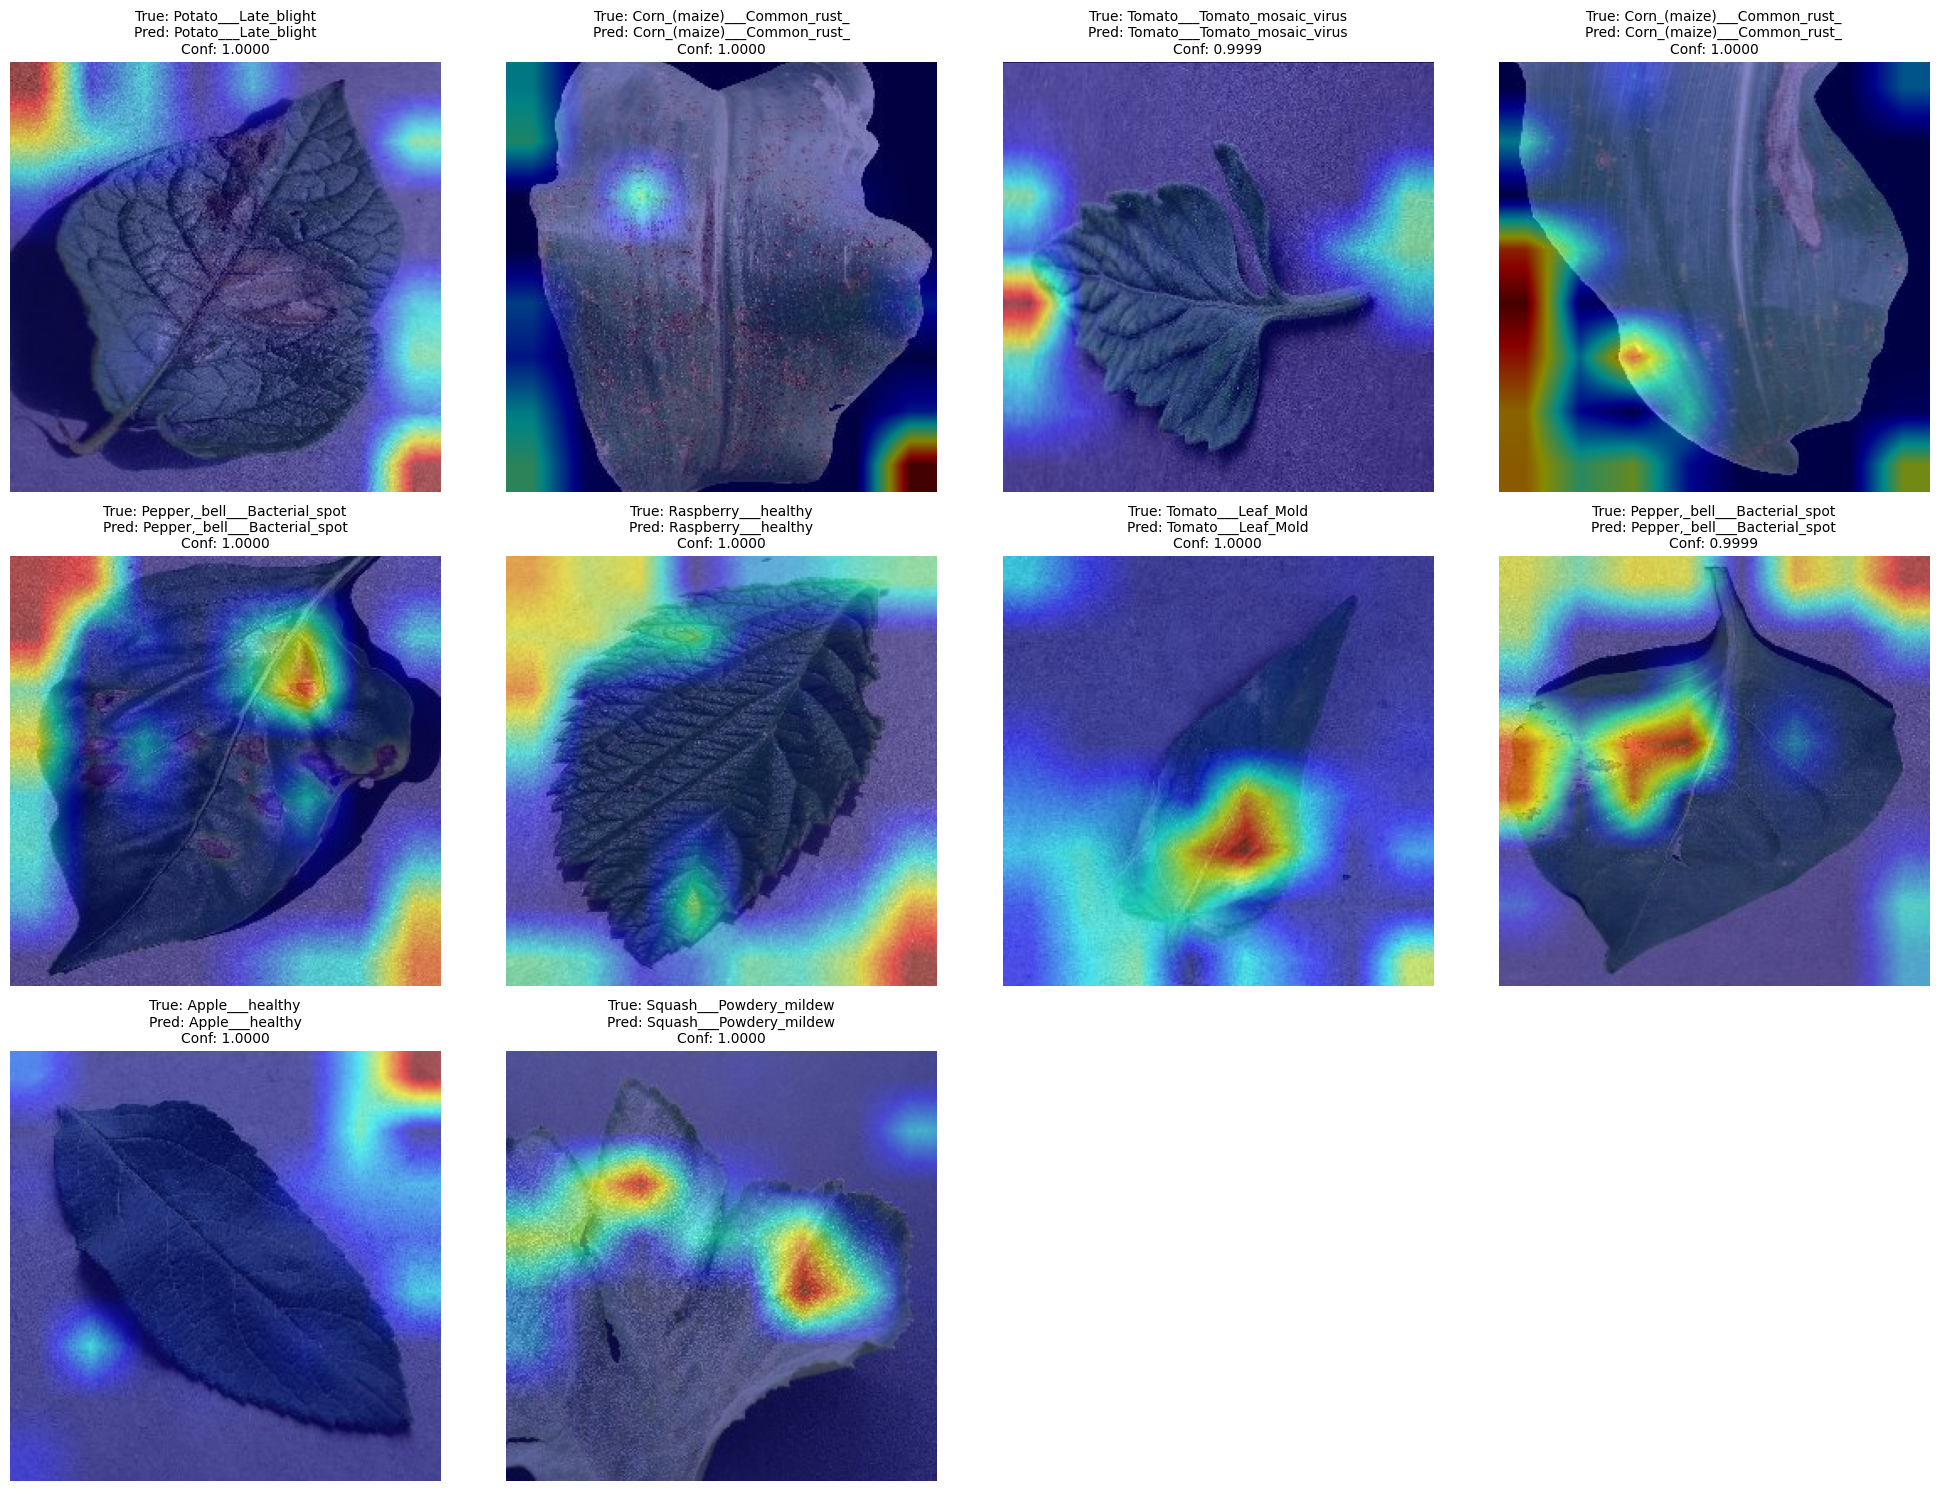

In [35]:
valid_dataset = ImageFolder(root=valid_path, transform=preprocess)

# Select 10 random indices
num_images_to_select = 10
random_indices = random.sample(range(len(valid_dataset)), num_images_to_select)

# Function to get predictions and CAM for selected images
results = []
for idx in random_indices:
    image, true_class = valid_dataset[idx]
    img_path = valid_dataset.samples[idx][0]  # Get the image path
    
    # Apply the prediction and CAM function
    predicted_idx, confidence, cam_image = get_prediction_and_cam(model, img_path)
    
    true_class_name = valid_dataset.classes[true_class]
    predicted_class_name = valid_dataset.classes[predicted_idx]
    
    results.append((true_class_name, predicted_class_name, confidence.cpu().data.numpy()[0], cam_image))

# Display results in a table
num_cols = 4
num_rows = (len(results) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))

for i, (true_class, pred_class, confidence, cam_image) in enumerate(results):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.imshow(cam_image)
    ax.axis('off')
    ax.set_title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.4f}", fontsize=10)

# Remove empty subplots
for i in range(len(results), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col] if num_rows > 1 else axes[col])

plt.tight_layout()
plt.show()

# 4 Calculate classification report and confusion matrix

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model = model.to(mps_device)

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []
all_confidences = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(mps_device)
        labels = labels.to(mps_device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidences, preds = torch.max(probabilities, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())


In [37]:
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.99      1.00      0.99       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(maize)___Northern_Leaf_Blight       0.99      0.99      0.

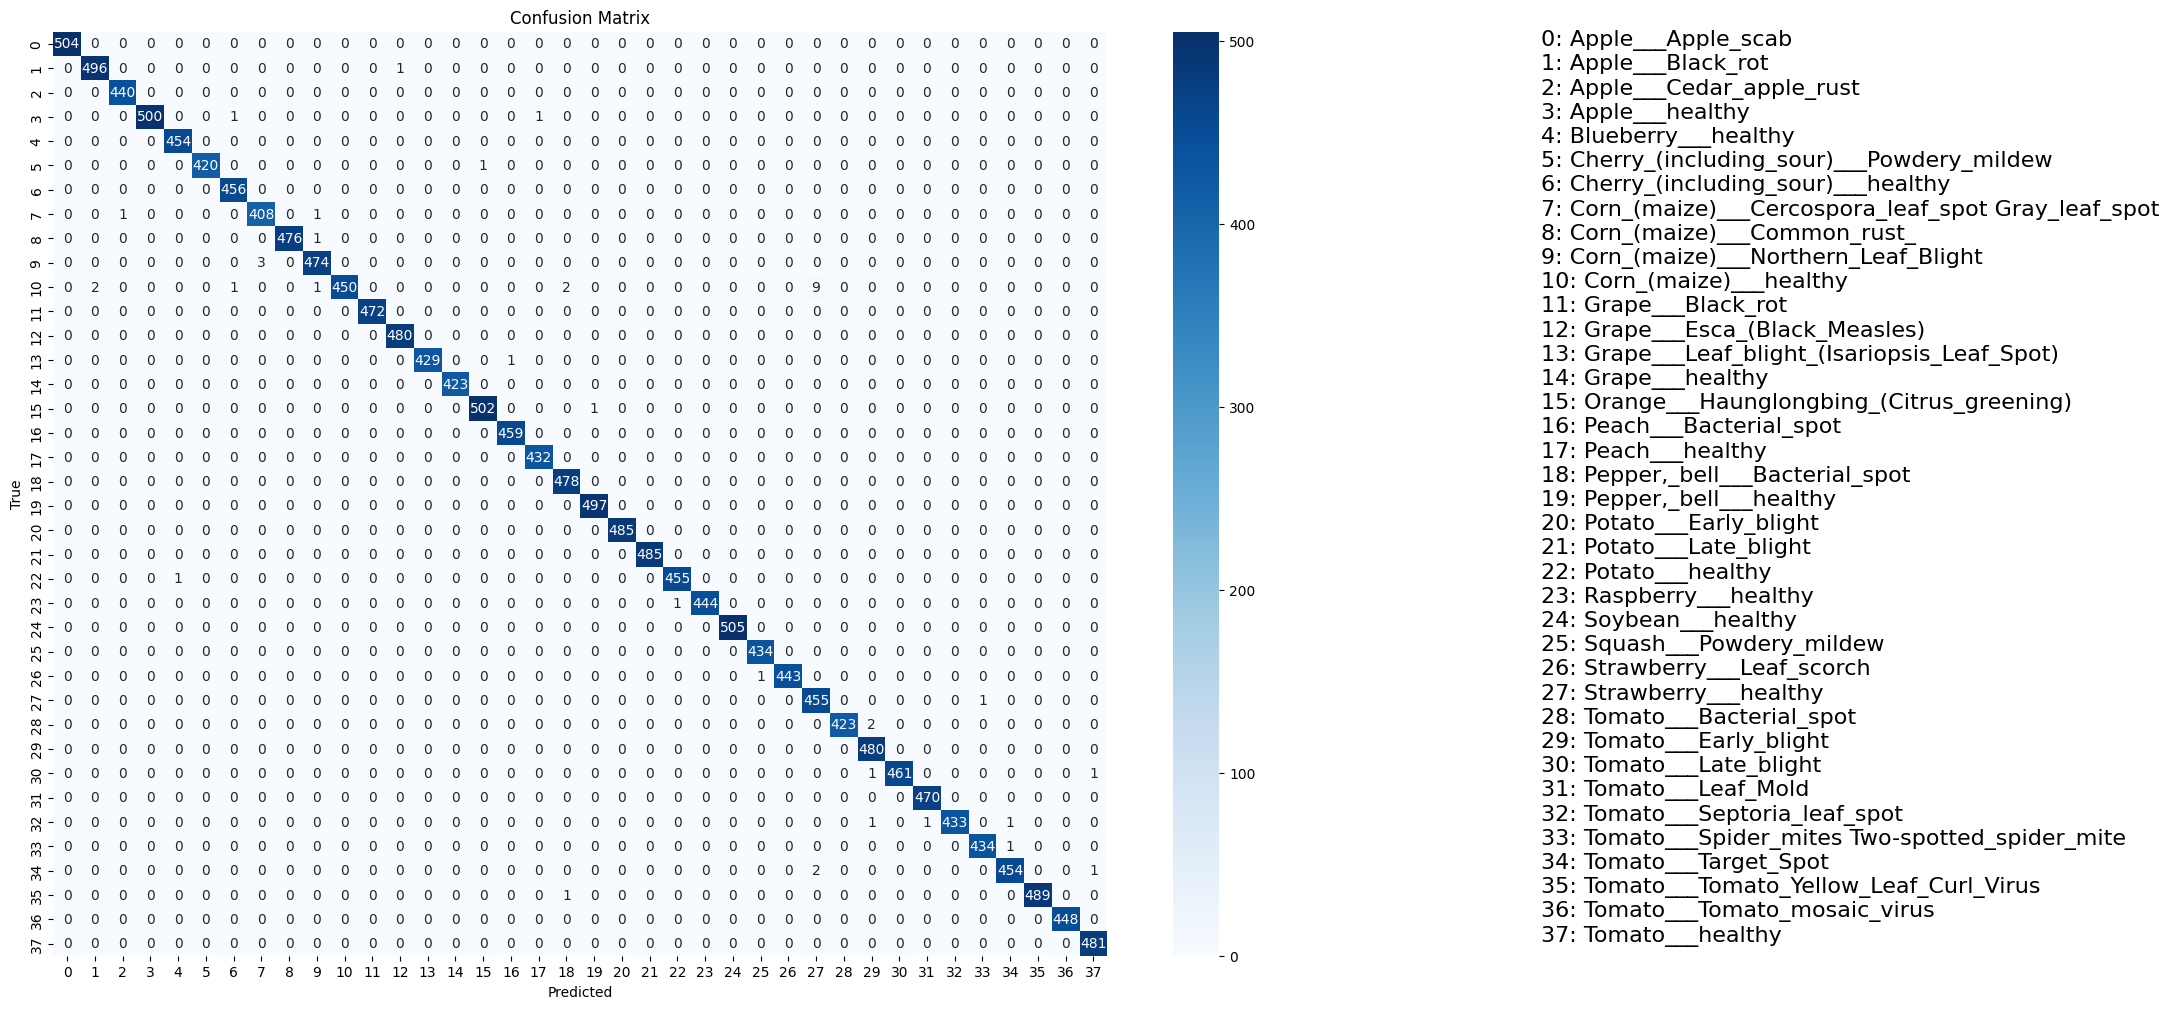

In [39]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(17, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(class_names)), yticklabels=range(len(class_names)))

# Add a legend for the class names
plt.gcf().text(1, 0.5,"\n".join([f"{i}: {name}" for i, name in enumerate(class_names)]),fontsize=16, verticalalignment='center', horizontalalignment='left')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Total number of wrong prediction on the valid set

total_sum = np.sum(cm)
diagonal_sum = np.trace(cm)
off_diagonal_sum = total_sum - diagonal_sum

print("Size of valid set:", total_sum)
print("Sum of wrong predictions (off-diagonal elements):", off_diagonal_sum)

Size of valid set: 17572
Sum of wrong predictions (off-diagonal elements): 43


In [1]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(all_confidences)), all_confidences)
plt.xlabel('Predictions')
plt.ylabel('Confidence')
plt.title('Confidences of all predictions on valid set')
plt.show()

NameError: name 'plt' is not defined